## Global To Dos:
* read paper
* [steps document](https://docs.google.com/document/d/1du2fcmVzTqnW0FWGmUxvpR2t6QEfwxDIrHSZs9k3HZM/edit?usp=sharing)

Section 1: Load and Preprocess Data

In [2]:
import utils_preprocessing as up
import utils as ut
import importlib
importlib.reload(ut)
importlib.reload(up)
from itertools import groupby
import yaml
import os
import textdistance
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Pre-processing 

Read in YAML and make PATH

In [3]:
#with open("config.yml", 'r') as ymlfile:
#    cfg = yaml.load(ymlfile)

#PATH = os.path.join(cfg['data']['Directory'] + ":" + os.sep, cfg['data']['Folder1'], cfg['data']['Folder2'], cfg['data']['Folder3']) # Alix Path

PATH = 'SOTU/'
#PATH = '/Users/aleistermontfort/Desktop/speeches' # Aleister Path
filetype = '*txt'

Read in Data

In [4]:
speeches, numpar = up.reading_data(PATH,'*.txt')

Create Noun Phrases

In [5]:
new_speeches = up.chunks(speeches, "spacy")

Clean Words & Lemmatize Noun Phrases: Spacy - Skip if used Regex Above

In [6]:
clean_speeches = up.clean_words(new_speeches)

Lemmatize Noun Phrases: Regex - Skip if Used Regex Above

In [7]:
words_changed = up.word_changes(clean_speeches, 0.5, 100)

In [8]:
phrases_lemmed = up.lemmed_phrases(words_changed, clean_speeches)

Counting Occurrence of Terms

In [9]:
counted_words = up.count_words(phrases_lemmed)

Limit List to Top 1000

In [10]:
top_words = up.top_x(counted_words, 1000)

limit paragraph phrases only to those in top 1000

In [11]:
limited_paragraphs = up.limit(phrases_lemmed, top_words)

## Periodization

In [12]:
tfidfs = up.corpus_tfidf(limited_paragraphs, counted_words, top_words)

In [13]:
periods, dissimilarity = up.periodization(tfidfs)

In [14]:
import operator
sorted_x = sorted(periods.items(), key=operator.itemgetter(1))
years = dissimilarity.index

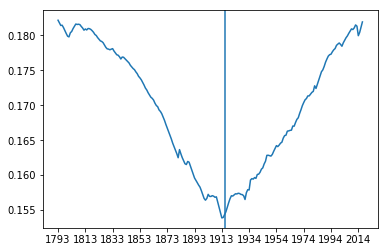

In [15]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.axvline(pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0]), 0,1)
plt.plot(x, y)
plt.show()

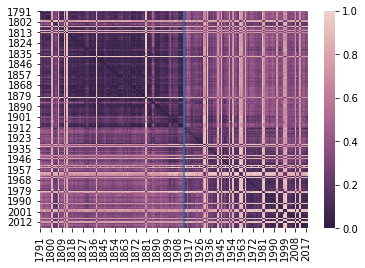

In [16]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(dissimilarity, cmap=cmap)
plt.axvline((pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0])), 0,1)
plt.show()

### Before

Before Years

In [17]:

before_1914 = years[:pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0])]
before_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in before_1914}

Before TFIDF

In [18]:
before_tfidfs = up.corpus_tfidf(before_dict, counted_words, top_words)

In [19]:
before_periods, before_dissimilarity = up.periodization(before_tfidfs)

### After

After Years

In [20]:
after_1914 = years[pd.to_numeric(sorted_x[0][0])-pd.to_numeric(years[0]):]
after_dict = {k: v for k, v in limited_paragraphs.items() if k[1] in after_1914}

After TFIDF

In [21]:
after_tfidfs = up.corpus_tfidf(after_dict, counted_words, top_words)

In [22]:
after_periods, after_dissimilarity = up.periodization(after_tfidfs)

In [23]:
new_periods = {**before_periods, **after_periods}

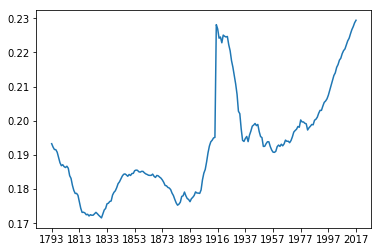

In [24]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

lists = sorted(new_periods.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

plt.plot(x, y)
plt.show()

## Co-Occurrence Matrix and Dissimilarity Topic Modeling

Build the co-occurrence matrix

In [25]:
pre_occur = ut.convert_dict_to_list(limited_paragraphs)

In [26]:
co_occur = ut.co_oc_matrix(pre_occur, True, True)

Do a cosine similarity

In [27]:
co_matrix = ut.pairwise_similarity(co_occur, 'cosine')

Do a paper dissimilarity

In [28]:
co_matrix_paper = ut.pairwise_similarity(co_occur, 'paper')

In [29]:
co_matrix.to_csv('spacy_cosine.csv')
co_matrix_paper.to_csv('spacy_paper.csv')

### Global Corpus

For the next section, if you're working on regex then include 'regex' in the parameters of the network graphing function. If you're working off spacy, include 'spacy' in the parameters of the network graphing function

In [30]:
#nounphrase = 'regex'
nounphrase = 'spacy'

Create network graph using community detection algorithms and paper's approach

['mr speaker', 'the congress', 'fellow citizen', 'the nation', 'selfgovernment', 'the preservation', 'liberty', 'the hand', 'the american people', 'our friend', 'a matter', 'the free world', 'aggression', 'a nation', 'arm', 'a country', 'us', 'peace', 'the price', 'strength', 'the burden', 'freedom', 'this chamber', 'washington', 'this congress', 'this administration', 'america', 'prosperity', 'our nation', 'the world', 'the blessing', 'our child', 'humanity', 'my duty', 'the progress', 'our relation', 'other nation', 'the foundation', 'the face', 'the people', 'million', 'their child', 'the state', 'the union', 'the situation', 'this time', 'a series', 'unemployment', 'inflation', 'percent', 'construction', 'thing', 'place', 'the past', 'a reduction', 'the rate', 'increase', 'the economy', 'job', 'the month', 'december', 'all american', 'tax', 'history', 'change', 'the increase', 'the beginning', 'the expense', 'year', 'power', 'resource', 'the growth', 'the cost', 'waste', 'fraud', '

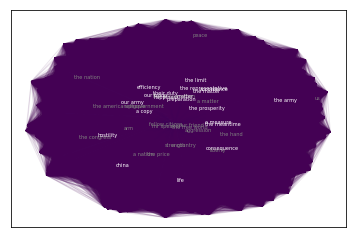

In [31]:
global_cda_paper = ut.network_graph(co_matrix_paper, 'community', nounphrase, 'global', 'paper')

Create network graph using community detection algorithms and cosine similarity

['mr speaker', 'the congress', 'the price', 'the people', 'million', 'the state', 'the union', 'a series', 'construction', 'a reduction', 'the rate', 'increase', 'tax', 'the increase', 'the beginning', 'the expense', 'the cost', 'waste', 'fraud', 'this year', 'the budget', 'office', 'a change', 'law', 'revenue', 'the number', 'employee', 'the department', 'the last year', 'the system', 'the time', 'a bill', 'the next year', 'operation', 'aid', 'the federal government', 'the national government', 'the return', 'transportation', 'the extent', 'hand', 'legislation', 'dollar', 'service', 'the land', 'the enactment', 'the house', 'detail', 'the past year', 'the year', 'the difference', 'a period', 'the condition', 'the present', 'the evil', 'my message', 'the experience', 'my opinion', 'combination', 'corporation', 'experience', 'money', 'the public', 'the place', 'the farmer', 'connection', 'both the power', 'the constitution', 'this power', 'practice', 'the several state', 'regulation', '

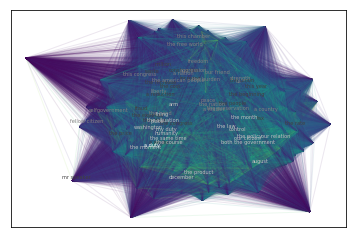

In [32]:
global_cda_cosine = ut.network_graph(co_matrix, 'community', nounphrase, 'global', 'cosine')

Create network graph using kmeans unsupervised clustering and paper's approach 

In [33]:
co_matrix_paper = pd.read_csv('spacy_paper.csv', index_col=0)

['mr speaker', 'the congress', 'fellow citizen', 'the nation', 'selfgovernment', 'the preservation', 'liberty', 'the hand', 'the american people', 'our friend', 'a matter', 'the free world', 'aggression', 'a nation', 'arm', 'a country', 'us', 'peace', 'the price', 'strength', 'the burden', 'freedom', 'this chamber', 'washington', 'this congress', 'this administration', 'america', 'prosperity', 'our nation', 'the world', 'the blessing', 'our child', 'humanity', 'my duty', 'the progress', 'our relation', 'other nation', 'the foundation', 'the face', 'the people', 'million', 'their child', 'the state', 'the union', 'the situation', 'this time', 'a series', 'unemployment', 'inflation', 'percent', 'construction', 'thing', 'place', 'the past', 'a reduction', 'the rate', 'increase', 'the economy', 'job', 'the month', 'december', 'all american', 'tax', 'history', 'change', 'the increase', 'the beginning', 'the expense', 'year', 'power', 'resource', 'the growth', 'the cost', 'waste', 'fraud', '

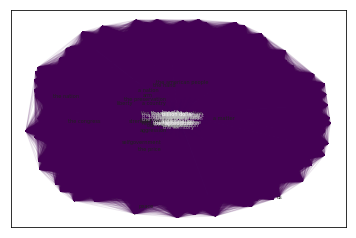

In [34]:
global_kmeans_paper = ut.network_graph(co_matrix_paper, 'kmeans', nounphrase, 'global', 'paper')

Create network graph using kmeans unsupervised clustering and cosine similarity 

['liberty', 'the american people', 'a nation', 'arm', 'a country', 'us', 'peace', 'strength', 'the burden', 'prosperity', 'the world', 'humanity', 'other nation', 'the foundation', 'the face', 'this time', 'the past', 'year', 'resource', 'the growth', 'thousand', 'the way', 'day', 'progress', 'our history', 'production', 'people', 'our effort', 'energy', 'business', 'need', 'something', 'our system', 'enterprise', 'reform', 'the first time', 'crime', 'society', 'the globe', 'the south', 'the force', 'support', 'violence', 'security', 'the peace', 'our people', 'a time', 'the process', 'course', 'the end', 'men', 'safety', 'man', 'a people', 'home', 'the day', 'the community', 'both our duty', 'trust', 'civilization', 'way', 'wealth', 'our country', 'the other hand', 'the need', 'the will', 'wisdom', 'his country', 'good', 'independence', 'the welfare', 'the history', 'both an opportunity', 'preparation', 'life', 'happiness', 'matter', 'death', 'population', 'the development', 'danger',

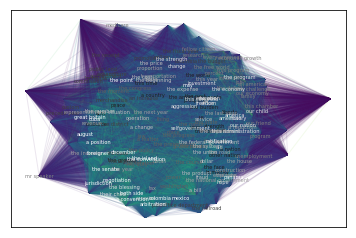

In [35]:
global_kmeans_cosine= ut.network_graph(co_matrix, 'kmeans', nounphrase, 'global', 'cosine')

### Before 1914 Corpus

First turn the before dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [36]:
before_occur = ut.convert_dict_to_list(before_dict)
co_before = ut.co_oc_matrix(before_occur, True, False)
before_cosine = ut.pairwise_similarity(co_before, 'cosine')
before_paper = ut.pairwise_similarity(co_before, 'paper')

In [37]:
before_paper.to_csv('before_spacy.csv')

Create network graph using community detection algorithm and paper dissimilarity

['the senate', 'house', 'representative']
['a period', 'law', 'the law', 'the condition', 'this nation', 'men', 'the nation', 'success', 'a people', 'the world', 'our future', 'the past', 'the event', 'our people', 'the men', 'the present', 'hope', 'us', 'home', 'the quality', 'the day', 'washington', 'this government', 'this country', 'our law', 'action', 'the community', 'a whole', 'the people', 'capital', 'our history', 'the growth', 'proportion', 'the evil', 'prosperity', 'the progress', 'both our duty', 'my message', 'length', 'the question', 'the regulation', 'trust', 'the experience', 'the past year', 'my opinion', 'power', 'combination', 'civilization', 'property', 'the right', 'society', 'the exercise', 'the name', 'corporation', 'experience', 'our system', 'government', 'the contrary', 'the effort', 'way', 'nothing', 'the way', 'the line', 'wealth', 'money', 'the public', 'the cost', 'production', 'the place', 'our country', 'the result', 'the farmer', 'the other hand', 'the 

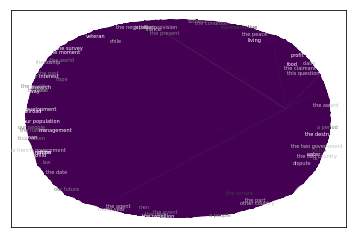

In [38]:
before_cda_paper = ut.network_graph(before_paper, 'community', nounphrase, 'before', 'paper')

Create network graph using community detection algorithm and cosine dissimilarity

['the senate', 'house', 'representative', 'success', 'the world', 'the event', 'hope', 'washington', 'this government', 'this country', 'our law', 'the progress', 'my message', 'length', 'the question', 'the regulation', 'property', 'the right', 'the line', 'the result', 'the congress', 'commerce', 'a view', 'justice', 'the enforcement', 'this purpose', 'effect', 'consideration', 'the subject', 'principle', 'the principle', 'protection', 'view', 'fact', 'a commission', 'the case', 'the view', 'the point', 'the conduct', 'condition', 'a part', 'his country', 'conformity', 'question', 'cuba', 'may', 'the island', 'the ground', 'part', 'independence', 'a convention', 'great britain', 'ratification', 'the convention', 'state', 'war', 'arbitration', 'difficulty', 'mexico', 'panama', 'negotiation', 'colombia', 'the canal', 'regard', 'administration', 'circumstance', 'the policy', 'america', 'importance', 'aggression', 'foreigner', 'the president', 'the philippine island', 'hawaii', 'term', '

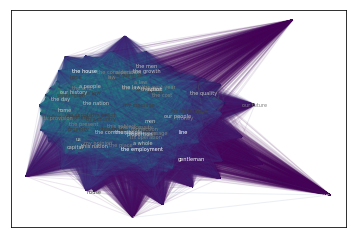

In [39]:
before_cda_cosine = ut.network_graph(before_cosine, 'community', nounphrase, 'before', 'cosine')

In [42]:
before_paper = pd.read_csv('before_spacy.csv', index_col=0)

Create network graph using kmeans and paper dissimilarity

['the senate', 'house', 'a period', 'law', 'the law', 'the condition', 'this nation', 'men', 'the nation', 'success', 'a people', 'the world', 'the past', 'the event', 'our people', 'the men', 'the present', 'hope', 'us', 'home', 'the quality', 'the day', 'washington', 'this government', 'this country', 'our law', 'action', 'the community', 'a whole', 'the people', 'capital', 'our history', 'the growth', 'proportion', 'the evil', 'prosperity', 'the progress', 'both our duty', 'my message', 'length', 'the question', 'the regulation', 'trust', 'the experience', 'the past year', 'my opinion', 'power', 'combination', 'civilization', 'property', 'the right', 'society', 'the exercise', 'the name', 'corporation', 'experience', 'our system', 'government', 'the contrary', 'the effort', 'way', 'nothing', 'the way', 'the line', 'wealth', 'money', 'the public', 'the cost', 'production', 'the place', 'our country', 'the result', 'the farmer', 'the other hand', 'the congress', 'connection', 'both th

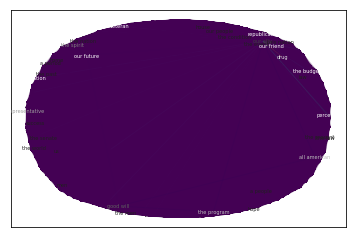

In [43]:
before_kmeans_paper = ut.network_graph(before_paper, 'kmeans', nounphrase, 'before', 'paper')

Create network graph using kmeans and cosine similarity

['a period', 'law', 'the law', 'the condition', 'the nation', 'success', 'the world', 'the present', 'us', 'the day', 'this country', 'action', 'the people', 'the evil', 'the progress', 'length', 'the question', 'the past year', 'power', 'property', 'the right', 'the exercise', 'experience', 'government', 'the contrary', 'nothing', 'the place', 'our country', 'the result', 'the congress', 'connection', 'both the power', 'the end', 'commerce', 'this subject', 'the consideration', 'a view', 'the necessity', 'the purpose', 'justice', 'this purpose', 'the direction', 'the country', 'effect', 'the advantage', 'this end', 'the wisdom', 'consideration', 'the subject', 'the best interest', 'principle', 'a system', 'time', 'the principle', 'the performance', 'interest', 'duty', 'protection', 'others', 'advantage', 'the application', 'view', 'fact', 'the case', 'the duty', 'my judgment', 'order', 'this time', 'the view', 'the use', 'the character', 'your attention', 'the form', 'the conduct', 'h

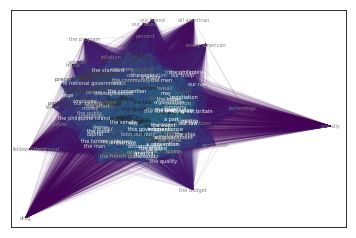

In [44]:
before_kmeans_cosine = ut.network_graph(before_cosine, 'kmeans', nounphrase, 'before', 'cosine')

### After 1914 Corpus

First turn the after dictionary into a co-occurrence matrix and create cosine and dissimilarity versions of it

In [45]:
after_occur = ut.convert_dict_to_list(after_dict)
co_after = ut.co_oc_matrix(after_occur, True, False)
after_cosine = ut.pairwise_similarity(co_after, 'cosine')
after_paper = ut.pairwise_similarity(co_after, 'paper')

In [46]:
after_paper.to_csv('after_spacy.csv')

Create network graph using community detection algorithm and paper dissimilarity

['mr speaker', 'the congress', 'fellow citizen', 'the nation', 'selfgovernment', 'the preservation', 'liberty', 'the hand', 'the american people', 'our friend', 'a matter', 'the free world', 'aggression', 'a nation', 'arm', 'a country', 'us', 'peace', 'the price', 'strength', 'the burden', 'freedom', 'this chamber', 'washington', 'this congress', 'this administration', 'america', 'prosperity', 'our nation', 'the world', 'the blessing', 'our child', 'humanity', 'my duty', 'the progress', 'our relation', 'other nation', 'the foundation', 'the face', 'the people', 'million', 'their child', 'the state', 'the union', 'the situation', 'this time', 'a series', 'unemployment', 'inflation', 'percent', 'construction', 'thing', 'place', 'the past', 'a reduction', 'the rate', 'increase', 'the economy', 'job', 'the month', 'december', 'all american', 'tax', 'history', 'change', 'the increase', 'the beginning', 'the expense', 'year', 'power', 'resource', 'the growth', 'the cost', 'waste', 'fraud', '

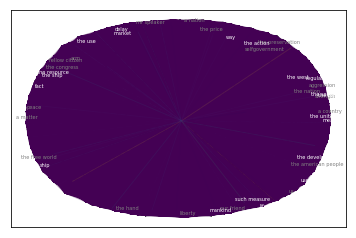

In [47]:
after_cda_paper = ut.network_graph(after_paper, 'community', nounphrase, 'after', 'paper')

Create network graph using community detection algorithm and cosine dissimilarity

['mr speaker', 'the congress', 'fellow citizen', 'this administration', 'my duty', 'the situation', 'a series', 'unemployment', 'inflation', 'percent', 'construction', 'a reduction', 'the rate', 'increase', 'the economy', 'december', 'tax', 'the increase', 'the expense', 'resource', 'the growth', 'the cost', 'waste', 'fraud', 'investment', 'the policy', 'the budget', 'a change', 'law', 'production', 'revenue', 'both the government', 'the number', 'employee', 'the department', 'education', 'business', 'need', 'control', 'program', 'august', 'a bill', 'health', 'the law', 'operation', 'capital', 'a program', 'our system', 'jurisdiction', 'aid', 'the federal government', 'the national government', 'the return', 'this program', 'transportation', 'the extent', 'hand', 'legislation', 'state', 'dollar', 'service', 'the land', 'the enactment', 'the house', 'the senate', 'a just subject', 'detail', 'order', 'the past year', 'respect', 'a policy', 'action', 'support', 'a position', 'the protecti

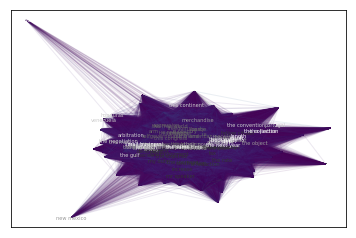

In [48]:
after_cda_cosine = ut.network_graph(after_cosine, 'community', nounphrase, 'after', 'cosine')

Create network graph using kmeans and paper dissimilarity

In [49]:
after_paper = pd.read_csv('after_spacy.csv', index_col=0)

['jurisdiction', 'a just subject', 'good faith', 'the trade', 'occasion', 'hostility', 'amity', 'this treaty', 'silver', 'an appropriation', 'the head', 'the receipt', 'our army', 'the ratification', 'the officer', 'pursuance', 'brazil', 'peru', 'a portion', 'circulation', 'those state', 'the exchange', 'the isthmus', 'vessel', 'the purchase', 'the public land', 'your consideration', 'the order', 'the existence', 'the public service', 'the appointment', 'combination', 'the whole country', 'florida', 'the ocean', 'the evil', 'execution', 'the labor', 'its operation', 'their duty', 'custom', 'territory', 'amount', 'the person', 'the river', 'importance', 'a course', 'the management', 'the troop', 'public land', 'chile', 'foreigner', 'these claim', 'louisiana', 'the principal', 'the legislature', 'the discharge', 'commissioner', 'the coast', 'the st', 'the canal', 'the inhabitant', 'the same period', 'the two government', 'the justice', 'the manner', 'the several state', 'venezuela', 'oth

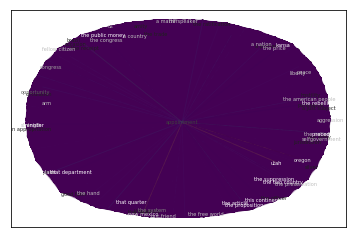

In [50]:
after_kmeans_paper = ut.network_graph(after_paper, 'kmeans', nounphrase, 'after', 'paper')

Create network graph using kmeans and cosine similarity

['fellow citizen', 'the preservation', 'their child', 'the union', 'december', 'a change', 'medicare', 'research', 'health', 'capital', 'welfare', 'good faith', 'a position', 'the rule', 'the water', 'the circumstance', 'manufacture', 'the port', 'great britain', 'ship', 'the west', 'merchandise', 'sea', 'the representative', 'our territory', 'occasion', 'hostility', 'amity', 'duty', 'the commerce', 'any time', 'our city', 'benefit', 'the treaty', 'the pacific', 'house', 'south america', 'an agreement', 'the standard', 'texas', 'question', 'foreign country', 'the agreement', 'our navy', 'italy', 'every part', 'nicaragua', 'difficulty', 'assurance', 'the balance', 'the whole', 'export', 'a majority', 'a right', 'relation', 'the prosperity', 'canada', 'korea', 'turkey', 'communication', 'democrat', 'republican', 'slavery', 'california', 'gold', 'our union', 'the party', 'that government', 'happiness', 'the performance', 'the art', 'a period', 'the sum', 'property', 'our law', 'length', '

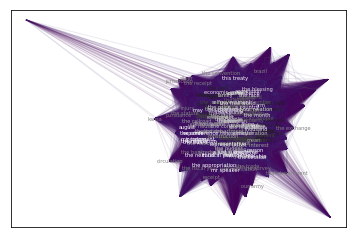

In [51]:
after_kmeans_cosine = ut.network_graph(after_cosine, 'kmeans', nounphrase, 'after', 'cosine')